<a href="https://colab.research.google.com/github/Ohara124c41/Frontier_AI-I/blob/main/KNN_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## k近傍法　(k-nearest neighbor algorithm, k-NN)
入力パターンに近いk個の学習パターンを取り上げ，最も多数を占めたカテゴリを入力パターンのカテゴリとする．
<br />
<br />
アルゴリズム：
1. 入力パターンと全ての学習パターンとの距離を計算する．
2.  距離の昇順に学習パターンをソートする．
3.  ソートした学習パターンの上位k個を取り上げ，最も出現回数の多いカテゴリを出力する．
<br />
<br />

<img src="http://drive.google.com/uc?export=view&id=1LBVmnghUEy2pLYIBl8M0utWUflh5hB9t" width=500 />

##  目次
- [目標](#目標)
- [下準備](#下準備)
- [距離関数の実装](#距離関数の実装)
- [k近傍法の実装](#k近傍法の実装)
- [k近傍法の実行](#k近傍法の実行)

<a name="目標"></a>
### 目標
- k近傍法で用いる距離関数を実装する．
    - [課題1： コサイン距離の実装](#コサイン距離)
    - [課題2： ユークリッド距離の実装](#ユークリッド距離)
- k近傍法のアルゴリズム全体を実装する．
    - [課題3： k近傍法の実装](#k近傍法)
- MNISTデータと二種類の距離関数を用いてk近傍法を実行する．

<a name="下準備"></a>
### 下準備


#### ライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from __future__ import print_function

In [2]:
from google.colab import drive # driveを接続
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# drive中の課題ファイルのあるフォルダへ移動
%cd /content/gdrive/MyDrive/__FrontierAI-I/handson20230509/handson20230509
from test_knn import *

/content/gdrive/MyDrive/__FrontierAI-I/handson20230509/handson20230509


#### MNISTデータの読み込み



- データをダウンロードする．一度ダウンロードすると，その後はデータを参照して読み込んでくれるので，毎回ダウンロードしなくても良くなる．
- X：画像データ(各画像784次元）， Y：ラベル
- mnistのデータは，0~255のint型で表されているが，これを**255で割って正規化**する．

In [5]:
X, Y = fetch_openml('mnist_784', version=1, data_home="./data/", return_X_y=True)
X = np.array(X/255.0, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)
# class数
class_num = 10
print("X.shape: " + str(X.shape), ", Y.shape: " + str(Y.shape))

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X.shape: (70000, 784) , Y.shape: (70000,)


#### データセットの可視化

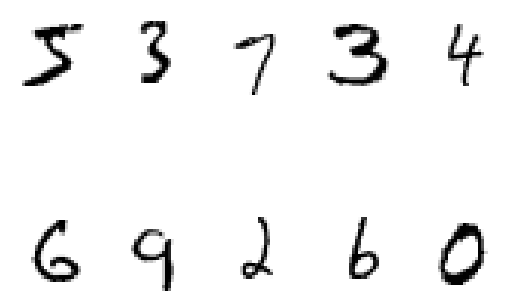

In [6]:
for i in range(class_num):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i * 6500].reshape(28, 28), cmap='gray_r')
    plt.axis("off")

#### データセットの削減
距離の計算にかなり時間がかかるためデータセットを70000から3000に削減する

In [7]:
np.random.seed(100)
random_sample = np.arange(len(X))
np.random.shuffle(random_sample)
X = X[random_sample[:3000]]
Y = Y[random_sample[:3000]]

#### 学習用・検証用・テスト用データの分割
- 学習用データ(train_x, train_y)：入力パターンのラベルを決定するために用いるデータ
- 検証用データ(val_x, val_y)：最適なハイパーパラメータ（k）を算出するためのデータ
- テスト用データ(test_x, test_y)：検証用データを用いて算出されたハイパーパラメータを用いて手法の性能をテストするためのデータ

In [8]:
#テスト用データを分ける
train_X, test_x, train_Y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
#学習用データと検証用データを分ける
train_x, val_x, train_y, val_y = train_test_split(train_X, train_Y, test_size=0.1, random_state=42)

In [9]:
print('train data:',train_x.shape,', train label:',train_y.shape)
print('val data:   ',val_x.shape,',    val label:   ',val_y.shape)
print('test data: ',test_x.shape,',   test label: ',test_y.shape)

train data: (2160, 784) , train label: (2160,)
val data:    (240, 784) ,    val label:    (240,)
test data:  (600, 784) ,   test label:  (600,)


### 距離関数の実装
<a name="距離関数の実装"></a>

<a name="コサイン距離"></a>
<h4><font color="Orange">
課題1：コサイン距離の実装
</h4>
</font>

- 関数：cosine_distance
 
  - 入力：$\boldsymbol{X}=(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots,\boldsymbol{x}_{N})^{T}\in\mathbb{R}^{N\times D},　\boldsymbol{Y}=(\boldsymbol{y}_1,\boldsymbol{y}_2,\cdots,\boldsymbol{y}_{M})^{T}\in\mathbb{R}^{M\times D}$
      
  - 出力：$\boldsymbol{Z}\in\mathbb{R}^{N\times M},　z_{nm}=\cos(\boldsymbol{x}_n,\boldsymbol{y}_m)$
    
    

- コサイン距離 :
$$ 
\cos(\boldsymbol{x},\boldsymbol{y}) = 1- \frac{\boldsymbol{x}\boldsymbol{y}}{|\boldsymbol{x}||\boldsymbol{y}|}\\
$$

<details>
<summary>
課題1：ヒント
</summary>
<ol>
    <li>
    
Zの初期化（Xの要素数$\times$Yの要素数）
    <ul> 
        <li>要素が0の配列を生成：`np.zeros(shape)`</li>
        <li>Xの要素数：`X.shape[0]`</li>
    </ul></li>
    <li>Z[n][m]にX[n]とY[m]のコサイン距離を代入
    <ul>
    <li>ベクトルX[n]のノルム計算：`np.linalg.norm(X[n])`</li>
    <li>ベクトルX[n]とY[m]の内積：`np.dot(X[n], Y[m])`</li>
    </ul></li>
    </ol>
</details>

In [32]:
def cosine_distance(X, Y):
        Z = np.zeros((X.shape[0], Y.shape[0]))
        for n in range(X.shape[0]):
          for m in range(Y.shape[0]):
            Z[n][m] = 1 - np.dot(X[n], Y[m]) / np.linalg.norm(X[n]) / np.linalg.norm( Y[m])
        return Z

#### 課題1のテスト
OKが表示されたら次に進む

In [34]:
test_cosine(cosine_distance)

OK


<a name="ユークリッド距離"></a>
<h4><font color="Orange">
課題2：ユークリッド距離の実装
</h4>
</font>

- 関数：euclidian_distance
  - 入力：$\boldsymbol{X}=(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots,\boldsymbol{x}_{N})^{T}\in\mathbb{R}^{N\times D},　\boldsymbol{Y}=(\boldsymbol{y}_1,\boldsymbol{y}_2,\cdots,\boldsymbol{y}_{M})^{T}\in\mathbb{R}^{M\times D}$
  
  - 出力：$\boldsymbol{Z}\in\mathbb{R}^{N\times M},　z_{nm}=d(\boldsymbol{x}_n,\boldsymbol{y}_m)$

- ユークリッド距離 :
$$ d(x,y)=\sqrt{(x_1-y_1)^2+(x_2-y_2)^2+\cdots(x_D-y_D)^2} $$

<details>
<summary>
課題2：ヒント
</summary>
<ol>
    <li>
    
Zの初期化（Xの要素数×Yの要素数）
    <ul> 
        <li>要素が0の配列を生成：`np.zeros(shape)`</li>
        <li>Xの要素数：`X.shape[0]`</li>
    </ul></li>
    <li>Z[n][m]にX[n]とY[m]のユークリッド距離を代入
    <ul>
    <li>ベクトルのノルム計算：`np.linalg.norm(X[n])`</li>
    </ul></li>
    </ol>
</details>

In [30]:
def euclidean_distance(X, Y):
        Z = np.zeros((X.shape[0], Y.shape[0]))
        for n in range(X.shape[0]):
          for m in range(Y.shape[0]):
            Z[n][m] = np.linalg.norm(X[n]-Y[m])
        return Z

#### 課題2のテスト
OKが表示されたら次に進む

In [35]:
test_euclidean(euclidean_distance)

OK


<a name="k近傍法の実装"></a>
### k近傍法の実装

<a name="k近傍法"></a>
<h4><font color="Orange">
課題3：k近傍法の実装
</h4>
</font>

- 関数：KNN.prediction
  - 入力：
    - 入力パターン：
  $\boldsymbol{X}=(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots,\boldsymbol{x}_N)^T\in\mathbb{R}^{N\times D}$
    - k近傍法のk: $k$
  - 出力：
    - 入力パターンの予測ラベル：
  $\boldsymbol{Y}=(y_1,y_2,\cdots,y_N)\in\mathbb{R}^{N}$
  - インスタンス変数
    - 学習データ：self.train_x
    - 学習ラベル：self.train_y
    - 距離関数：distance_func()
    

<details>
<summary>
課題3：ヒント1（入力パターンXと全ての学習パターンself.train_xとの距離を計算する）
</summary>
<ul>
        <li>
        
`distance_matrix = self.distance_func(X, self.train_x)`<br>
            <img src="https://drive.google.com/uc?export=download&id=16uPwCC1eCXweQEMh1YfqUUf4uw17n-Wm" width="360" height="280"></li>
</ul>
</details>

<details>
<summary>
課題3：ヒント2（距離の昇順に学習パターンをソートする）
</summary>
    <ul>
    <li>
    
`sort_index = np.argsort(distance_matrix, axis = 1)`<br>
    <img src="https://drive.google.com/uc?export=download&id=1vEbZ-JVtGw9flDAH2D78NMDMkKb7i08-" width="600" height="300"></li>
   </ul>

<details>
<summary>
課題3：ヒント3（ソートした学習パターンの上位k個を取り上げ，最も出現回数の多いカテゴリを出力する ）
</summary>
<ul>
    <li>
    
上位k個のインデックスを取り出す：`nearest_k = sort_index[???]`</li>
    <li>上位k個のラベルを取り出す：`labels = self.train_y[nearest_k]`</li>
    <li>上位k個のラベルに各ラベルが何個ずつ含まれるか調べる：<br>
    <img src="https://drive.google.com/uc?export=download&id=1TBgXDPKdDwKXYcJWPkkpT7cDSvR3NA_M"　width="600" height="128">
    <ul>
        <li>np.eye(class_num)[labels]でラベルをone-hot表現にする<br>
        <img src="https://drive.google.com/uc?export=download&id=11KSxXUN2lnMxOTj6G4c6OwyltxTnDh62"　width="350" height="300">
        <li>axis=1方向に合計をとる<br>
        <img src="https://drive.google.com/uc?export=download&id=10eN_L6t1wN3B1Gw-m2Zg0mxThfssfAAg"　width="350" height="100"><br>
     <li>上位k個のラベルで最も多いラベルを調べる：np.argmax()</li>
    </ul></li>
    </ul>
</details>

In [36]:
class KNN:
    def __init__(self, x, y, func=cosine_distance):
        self.train_x = x
        self.train_y = y
        self.distance_func = func
    
    #入力パターンに対して予測ラベルを返す
    def prediction(self, X, k):
        distance_matrix = self.distance_func(X, self.train_x)
        sort_index = np.argsort(distance_matrix, axis=1)
        nearest_k = sort_index[:, :k]
        labels = self.train_y[nearest_k]
        label_num = np.sum(np.eye(class_num)[labels], axis=1)
        Y = np.argmax(label_num, axis=1)
        return Y
    
    #予測データと正解データを用いてaccuracyを計算する
    def get_accuracy(self, pred, real, eval_func=accuracy_score):
        accuracy = eval_func(pred, real)
        return accuracy
    
    # 最適なkを見つけるためにkを変化させて予測を行い，最も性能が高いkを返す
    def find_k(self, val_x, val_y, k_list):
        score_list = []
        #for k in tqdm(k_list): 
        for k in k_list:
            pred = self.prediction(val_x, k)
            accuracy = self.get_accuracy(pred, val_y)
            print('k：{0}, accuracy：{1:.5f}'.format(k,accuracy))
            score_list.append(accuracy)

        top_ind = np.argmax(score_list)
        best_k = k_list[top_ind]
        print('best k : {0}, val score : {1:.5f}'.format(best_k,score_list[top_ind]))
        return best_k

#### 課題3のテスト
OKが表示されたら次に進む

In [37]:
test_knn(KNN)

OK


### k近傍法の実行
<a name="k近傍法の実行"></a>

#### コサイン距離を用いる場合

In [38]:
#インスタンス生成
knn = KNN(train_x, train_y, func = cosine_distance)
#検証用データval_xを用いて最適なkを算出する
k_list = np.arange(1,21,2)
best_k = knn.find_k(val_x, val_y, k_list)
#検証用データで算出したkを用いてテストデータのクラスを予測する
pred_y = knn.prediction(test_x, best_k)
#正解率の計算
result = knn.get_accuracy(pred_y, test_y)
print('test_accuracy :　{0:.5f}'.format(result))

k：1, accuracy：0.92083
k：3, accuracy：0.92083
k：5, accuracy：0.92917
k：7, accuracy：0.91667
k：9, accuracy：0.91250
k：11, accuracy：0.92500
k：13, accuracy：0.92917
k：15, accuracy：0.92917
k：17, accuracy：0.92500
k：19, accuracy：0.92083
best k : 5, val score : 0.92917
test_accuracy :　0.92167


#### ユークリッド距離を用いる場合

In [ ]:
knn = KNN(train_x, train_y, func = euclidean_distance)
#検証用データval_xを用いて最適なkを算出する
k_list = np.arange(1,21,2)
best_k = knn.find_k(val_x, val_y, k_list)
#検証用データで算出したkを用いてテストデータのクラスを予測する
pred_y = knn.prediction(test_x, best_k)
#正解率の計算
result = knn.get_accuracy(pred_y, test_y)
print('test_accuracy :　{0:.5f}'.format(result))

k：1, accuracy：0.90833
k：3, accuracy：0.91667
k：5, accuracy：0.92083
k：7, accuracy：0.91667


test_accuracyがいずれの場合も約90パーセントであれば正解である．

k近傍法はシンプルだが，入力パターンと学習パターンの全てに対して距離を計算しなければならないので，識別に時間がかかる．<br>
コサイン距離やユークリッド距離を計算する際にfor文を使わない実装例を解答に示したので確認してみよう．